In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import networkx as nx
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import subprocess
import pandas as pd

from nosh.sim import NoshGraphSimulation
import nosh.utils as uu
import itertools

from tqdm.auto import tqdm

In [39]:
def run_simulation_mc(
        num_mc, 
        buyer_transact_probability, 
        seller_unstake_probability, 
        add_delete_maintain_probs,
        alpha_vec,
        num_steps=100, 
        seed_start=1234
    ):
    # seed simulation with starting graph

    initial_buyers_kwargs = [
        {'starting_tokens': 0, 'transact_probability': buyer_transact_probability}, 
        {'starting_tokens': 0, 'transact_probability': buyer_transact_probability}, 
        {'starting_tokens': 0, 'transact_probability': buyer_transact_probability}, 
    ]
    initial_sellers_kwargs = [
        {'starting_tokens': 0, 'transact_probability': 1.0, 'unstake_probability': seller_unstake_probability}, 
        {'starting_tokens': 0, 'transact_probability': 1.0, 'unstake_probability': seller_unstake_probability}, 
        {'starting_tokens': 0, 'transact_probability': 1.0, 'unstake_probability': seller_unstake_probability}, 
    ]
    new_buyer_kwargs = {'starting_tokens': 0, 'transact_probability': buyer_transact_probability}
    new_seller_kwargs = {'starting_tokens': 0, 'transact_probability': 1.0, 'unstake_probability': seller_unstake_probability}
    

    sim_results = []
    for ii in range(num_mc):
        simulation = NoshGraphSimulation(
            initial_buyers_kwargs, 
            initial_sellers_kwargs,
            new_buyer_kwargs,
            new_seller_kwargs,
            seed=seed_start + ii
        )
        graph_evolution_metrics = simulation.run(
            num_steps, 
            add_delete_maintain_probs,
            alpha_vec
        )
        sim_results.append(graph_evolution_metrics)
    return sim_results

In [40]:
buyer_transact_probabilities = [0.2, 0.8]
seller_unstake_probabilities = [0.2, 0.8]
num_mc = 10
time_steps = 100
simulation_configs = list(itertools.product(buyer_transact_probabilities, seller_unstake_probabilities))

add_delete_maintain_probs = np.ones((time_steps, 3)) * [0.3, 0.3, 0.4]
alpha_vec = np.ones((time_steps,)) * 0.5

cfg2results = {}
for cfg in tqdm(simulation_configs):
    buyer_transact_probability, seller_unstake_probability = cfg
    cfg_results = run_simulation_mc(
        num_mc, 
        buyer_transact_probability, 
        seller_unstake_probability, 
        add_delete_maintain_probs,
        alpha_vec,
        num_steps=time_steps, 
        seed_start=1234
    )
    cfg2results[cfg] = cfg_results

  0%|          | 0/4 [00:00<?, ?it/s]

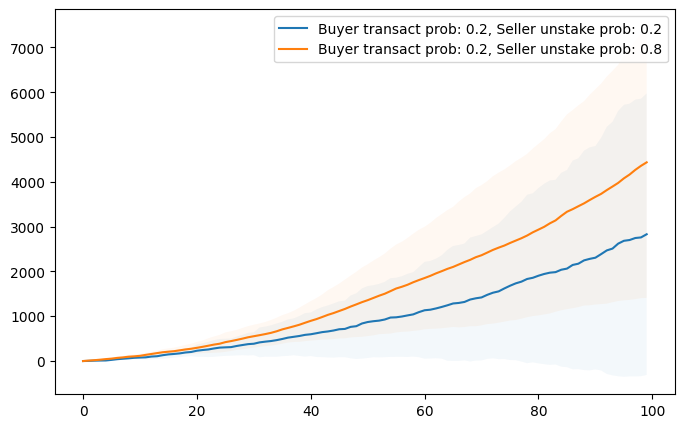

In [41]:
# plot total supply over time
fig, ax = plt.subplots(1, 1, figsize=(8,5))

# since unstaking probability controls the total supply, we will fix the buyer transact probability
# for these plots
plot_configs = [(0.2, 0.2), (0.2, 0.8)]

for cfg in plot_configs:
    results = cfg2results[cfg]
    total_supply_mcmc_matrix = np.zeros((num_mc, time_steps))
    # extract total supply into a matrix for all mcmc runs
    for ii, result_by_time in enumerate(results):
        for jj, result in enumerate(result_by_time):
            total_supply_mcmc_matrix[ii, jj] = result['total_supply']
    
    # plot mean and confidence intervals
    mean_total_supply = np.mean(total_supply_mcmc_matrix, axis=0)
    std_total_supply = np.std(total_supply_mcmc_matrix, axis=0)
    ax.plot(mean_total_supply, label=f"Buyer transact prob: {cfg[0]}, Seller unstake prob: {cfg[1]}")
    ax.fill_between(
        np.arange(time_steps),
        mean_total_supply - std_total_supply,
        mean_total_supply + std_total_supply,
        alpha=0.05
    )
plt.legend()

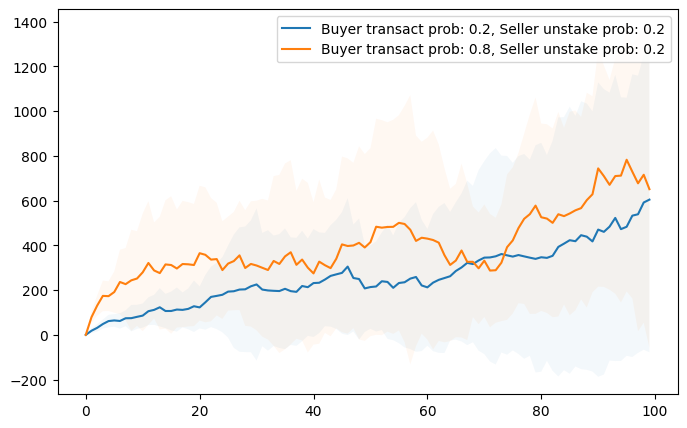

In [46]:
# plot total graph weight over time
fig, ax = plt.subplots(1, 1, figsize=(8,5))

# since transaction probability controls how connected sellers will become, we will fix unstaking probability
# for these plots
plot_configs = [(0.2, 0.2), (0.8, 0.2)]

for cfg in plot_configs:
    results = cfg2results[cfg]
    total_weight_matrix = np.zeros((num_mc, time_steps))
    # extract total supply into a matrix for all mcmc runs
    for ii, result_by_time in enumerate(results):
        weight_matrix = uu.total_weight_metric_fn(result_by_time)
        total_weight_matrix[ii, :] = np.nansum(weight_matrix, axis=0)
    
    # plot mean and confidence intervals
    mean = np.mean(total_weight_matrix, axis=0)
    std = np.std(total_weight_matrix, axis=0)
    ax.plot(mean, label=f"Buyer transact prob: {cfg[0]}, Seller unstake prob: {cfg[1]}")
    ax.fill_between(
        np.arange(time_steps),
        mean - std,
        mean + std,
        alpha=0.05
    )
plt.legend()

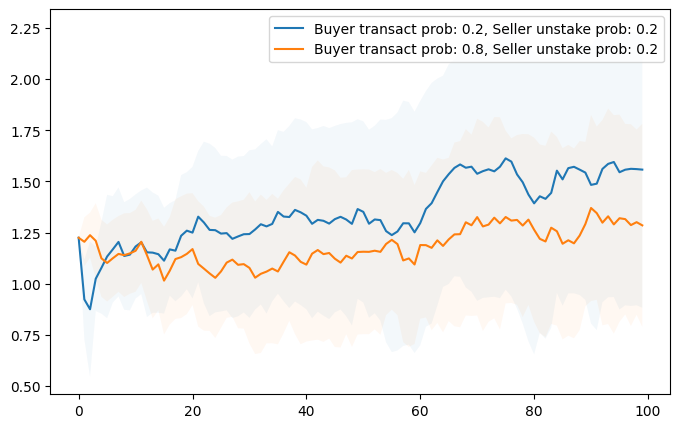

In [45]:
# plot eigenvector centrality over time
fig, ax = plt.subplots(1, 1, figsize=(8,5))

# since transaction probability controls how connected sellers will become, we will fix unstaking probability
# for these plots
plot_configs = [(0.2, 0.2), (0.8, 0.2)]

for cfg in plot_configs:
    results = cfg2results[cfg]
    total_ec_matrix = np.zeros((num_mc, time_steps))
    # extract total supply into a matrix for all mcmc runs
    for ii, result_by_time in enumerate(results):
        ec_matrix = uu.eigenvector_centrality_metric_fn(result_by_time)
        total_ec_matrix[ii, :] = np.nansum(ec_matrix, axis=0)
    
    # plot mean and confidence intervals
    mean = np.mean(total_ec_matrix, axis=0)
    std = np.std(total_ec_matrix, axis=0)
    ax.plot(mean, label=f"Buyer transact prob: {cfg[0]}, Seller unstake prob: {cfg[1]}")
    ax.fill_between(
        np.arange(time_steps),
        mean - std,
        mean + std,
        alpha=0.05
    )
plt.legend()

Text(0.5, 1.0, 'Total Graph Value')

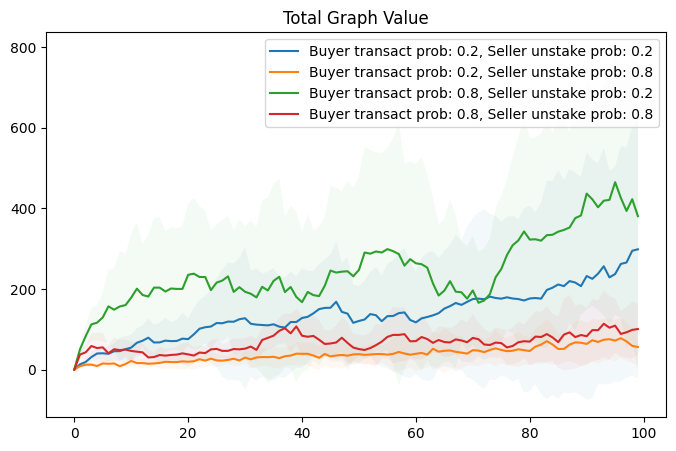

In [48]:
# get the graph total value
# plot eigenvector centrality over time
fig, ax = plt.subplots(1, 1, figsize=(8,5))

# since transaction probability controls how connected sellers will become, we will fix unstaking probability
# for these plots
plot_configs = [(0.2, 0.2), (0.2, 0.8),  (0.8, 0.2), (0.8, 0.8)]

for cfg in plot_configs:
    results = cfg2results[cfg]
    graphvalue_matrix = np.zeros((num_mc, time_steps))
    # extract total supply into a matrix for all mcmc runs
    for ii, result_by_time in enumerate(results):
        seller2tv = uu.seller_totalvalue_metric_fn(result_by_time)
        sum_sellertv_bytime = np.nansum(seller2tv, axis=0)
        graphvalue_matrix[ii, :] = sum_sellertv_bytime
    
    # plot mean and confidence intervals
    mean = np.mean(graphvalue_matrix, axis=0)
    std = np.std(graphvalue_matrix, axis=0)
    ax.plot(mean, label=f"Buyer transact prob: {cfg[0]}, Seller unstake prob: {cfg[1]}")
    ax.fill_between(
        np.arange(time_steps),
        mean - std,
        mean + std,
        alpha=0.05
    )
plt.legend()
plt.title('Total Graph Value')
plt.xlabel('Time')